# Measuring Monotonic Relationships
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Reference: DeFusco, Richard A. "Tests Concerning Correlation: The Spearman Rank Correlation Coefficient." Quantitative Investment Analysis. Hoboken, NJ: Wiley, 2007


Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

The Spearman Rank Correlation Coefficient allows us to determine whether or not two data series move together; that is, when one increases (decreases) the other also increases (decreases). This is more general than a linear relationship; for instance, $y = e^x$ is a monotonic function, but not a linear one. Therefore, in computing it we compare not the raw data but the ranks of the data.

This is useful when your data sets may be in different units, and therefore not linearly related (for example, the price of a square plot of land and its side length, since the price is more likely to be linear in the area). It's also suitable for data sets which not satisfy the assumptions that other tests require, such as the observations being normally distributed as would be necessary for a t-test.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [2]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print 'Raw data: ', l
print 'Ranking: ', list(stats.rankdata(l, method='average'))

Raw data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


## Spearman Rank Correlation

### Intuition

The intution is now that instead of looking at the relationship between the two variables, we look at the relationship between the ranks. This is robust to outliers and the scale of the data.

### Definition

The argument `method='average'` indicates that when we have a tie, we average the ranks that the numbers would occupy. For example, the two 5's above, which would take up ranks 1 and 2, each get assigned a rank of $1.5$.

To compute the Spearman rank correlation for two data sets $X$ and $Y$, each of size $n$, we use the formula
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference between the ranks of the $i$th pair of observations, $X_i - Y_i$.

The result will always be between $-1$ and $1$. A positive value indicates a positive relationship between the variables, while a negative value indicates an inverse relationship. A value of 0 implies the absense of any monotonic relationship. This does not mean that there is no relationship; for instance, if $Y$ is equal to $X$ with a delay of 2, they are related simply and precisely, but their $r_S$ can be close to zero:

##Experiment

Let's see what happens if we draw $X$ from a poisson distribution (non-normal), and then set $Y = e^X + \epsilon$ where $\epsilon$ is drawn from another poisson distribution. We'll take the spearman rank and the correlation coefficient on this data and then run the entire experiment many times. Because $e^X$ produces many values that are far away from the rest, we can this of this as modeling 'outliers' in our data. Spearman rank compresses the outliers and does better at measuring correlation. Normal correlation is confused by the outliers and on average will measure less of a relationship than is actually there.

In [3]:
## Let's see an example of this
n = 100

def compare_correlation_and_spearman_rank(n, noise):
    X = np.random.poisson(size=n)
    Y = np.exp(X) + noise * np.random.normal(size=n)

    Xrank = stats.rankdata(X, method='average')
    # n-2 is the second to last element
    Yrank = stats.rankdata(Y, method='average')

    diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
    r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
    c_c = np.corrcoef(X, Y)[0,1]
    
    return r_s, c_c

experiments = 1000
spearman_dist = np.ndarray(experiments)
correlation_dist = np.ndarray(experiments)
for i in range(experiments):
    r_s, c_c = compare_correlation_and_spearman_rank(n, 1.0)
    spearman_dist[i] = r_s
    correlation_dist[i] = c_c
    
print 'Spearman Rank Coefficient: ' + str(np.mean(spearman_dist))
# Compare to the regular correlation coefficient
print 'Correlation coefficient: ' + str(np.mean(correlation_dist))

Spearman Rank Coefficient: 0.877239879988
Correlation coefficient: 0.773013362941


Let's take a look at the distribution of measured correlation coefficients and compare the spearman with the regular metric.

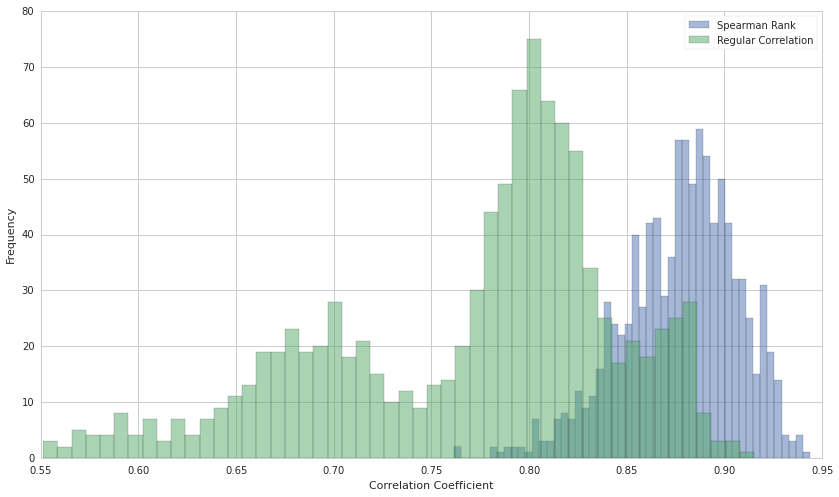

In [4]:
plt.hist(spearman_dist, bins=50, alpha=0.5)
plt.hist(correlation_dist, bins=50, alpha=0.5)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency');

Now let's see how the Spearman rank and Regular coefficients cope when we add more noise to the situation.

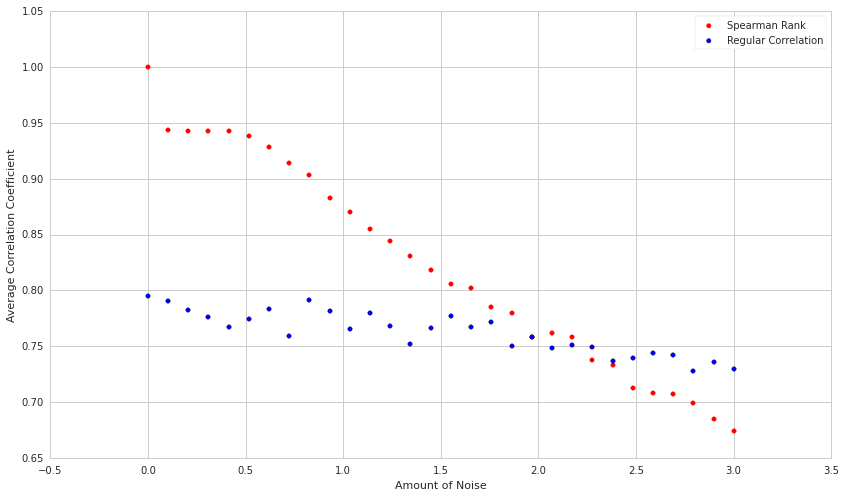

In [5]:
n = 100
noises = np.linspace(0, 3, 30)
experiments = 100
spearman = np.ndarray(len(noises))
correlation = np.ndarray(len(noises))

for i in range(len(noises)):
    # Run many experiments for each noise setting
    rank_coef = 0.0
    corr_coef = 0.0
    noise = noises[i]
    for j in range(experiments):
        r_s, c_c = compare_correlation_and_spearman_rank(n, noise)
        rank_coef += r_s
        corr_coef += c_c
    spearman[i] = rank_coef/experiments
    correlation[i] = corr_coef/experiments
    
plt.scatter(noises, spearman, color='r')
plt.scatter(noises, correlation)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Amount of Noise')
plt.ylabel('Average Correlation Coefficient')

We can see that the Spearman rank correlation copes with the non-linear relationship much better at most levels of noise. Interestingly, at very high levels, it seems to do worse than regular correlation.

##Delay in correlation

Of you might have the case that one process affects another, but after a time lag. Now let's see what happens if we add the delay.

In [6]:
n = 100

X = np.random.rand(n)
Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata([1,1] + list(X[:(n-2)]), method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
print r_s

-0.00584158415842


Sure enough, the relationship is not detected. It is important when using both regular and spearman correlation to check for lagged relationships by offsetting your data and testing for different offset values.

##Built-In Function

We can also use the `spearmanr` function in the `scipy.stats` library:

In [7]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X, Y)
print 'Spearman Rank Coefficient: ', r_s[0]
print 'p-value: ', r_s[1]

Spearman Rank Coefficient:  0.236363636364
p-value:  0.510885317515


We now have ourselves an $r_S$, but how do we interpret it? It's positive, so we know that the variables are not anticorrelated. It's not very large, so we know they aren't perfectly positively correlated, but it's hard to say from a glance just how significant the correlation is. Luckily, `spearmanr` also computes the p-value for this coefficient and sample size for us. We can see that the p-value here is above 0.05; therefore, we cannot claim that $X$ and $Y$ are correlated.

##Real World Example: Mutual Fund Expense Ratio

Now that we've seen how Spearman rank correlation works, we'll quickly go through the process again with some real data. For instance, we may wonder whether the expense ratio of a mutual fund is indicative of its three-year Sharpe ratio. That is, does spending more money on administration, management, etc. lower the risk or increase the returns? Quantopian does not currently support mutual funds, so we will pull the data from Yahoo Finance. Our p-value cutoff will be the usual default of 0.05.

### Data Source

Thanks to [Matthew Madurski](https://github.com/dursk) for the data. To obtain the same data:

1. Download the csv from this link. https://gist.github.com/dursk/82eee65b7d1056b469ab
2. Upload it to the 'data' folder in your research account.

Spearman Rank Coefficient:  -0.237573932355
p-value:  0.0167465097116


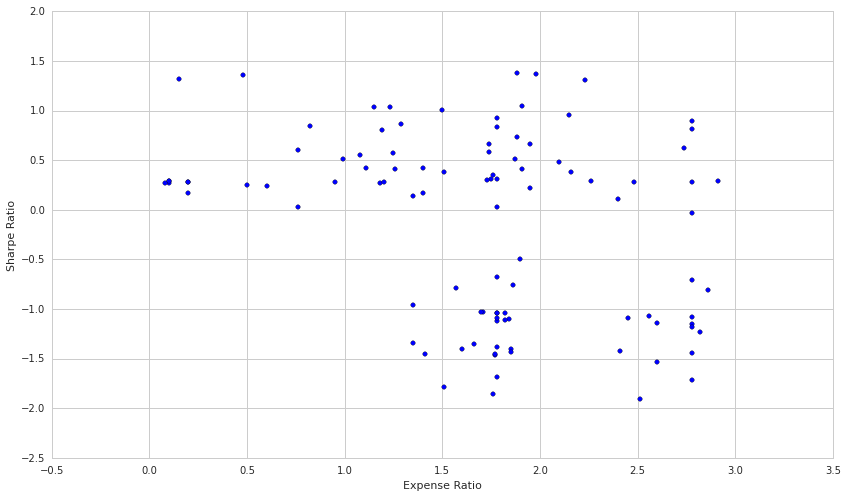

In [8]:
mutual_fund_data = local_csv('mutual_fund_data.csv')
expense = mutual_fund_data['Annual Expense Ratio'].values
sharpe = mutual_fund_data['Three Year Sharpe Ratio'].values

plt.scatter(expense, sharpe)
plt.xlabel('Expense Ratio')
plt.ylabel('Sharpe Ratio')

r_S = stats.spearmanr(expense, sharpe)
print 'Spearman Rank Coefficient: ', r_S[0]
print 'p-value: ', r_S[1]

Our p-value is below the cutoff, which means we accept the hypothesis that the two are correlated. The negative coefficient indicates that there is a negative correlation, and that more expensive mutual funds have worse sharpe ratios. However, there is some weird clustering in the data, it seems there are expensive groups with low sharpe ratios, and a main group whose sharpe ratio is unrelated to the expense. Further analysis would be required to understand what's going on here.

## Real World Use Case: Evaluating a Ranking Model

### NOTE: [Factor Analysis](https://www.quantopian.com/lectures/factor-analysis) now covers this topic in much greater detail

Let's say that we have some way of ranking securities and that we'd like to test how well our ranking performs in practice. In this case our model just takes the mean daily return for the last month and ranks the stocks by that metric. 

We hypothesize that this will be predictive of the mean returns over the next month. To test this we score the stocks based on a lookback window, then take the spearman rank correlation of the score and the mean returns over the walk forward month.

Our Scores

Equity(24757 [A])      -0.000624
Equity(2 [AA])         -0.003646
Equity(47842 [AAC])     0.002745
Equity(45971 [AAL])     0.005677
Equity(45415 [AAMC])   -0.020459
Equity(21 [AAME])       0.002207
Equity(523 [AAN])       0.003765
Equity(45503 [AAOI])    0.004758
Equity(9681 [AAON])     0.004228
Equity(23175 [AAP])     0.003887
Equity(24 [AAPL])      -0.001870
Equity(40707 [AAT])     0.001433
Equity(27922 [AAU])    -0.000576
Equity(27884 [AAV])     0.003966
Equity(47422 [AAVL])    0.017364
Equity(28378 [AAWW])    0.004993
Equity(66 [AB])        -0.000934
Equity(39927 [ABAC])   -0.005923
Equity(31 [ABAX])       0.000679
Equity(22574 [ABB])    -0.002108
Equity(43694 [ABBV])   -0.002467
Equity(22954 [ABC])    -0.000335
Equity(11232 [ABCB])    0.002142
Equity(39052 [ABCD])   -0.000333
Equity(23176 [ABCO])    0.008131
Equity(47935 [ABCW])    0.002776
Equity(46877 [ABDC])   -0.000825
Equity(45840 [ABEV])    0.000035
Equity(24761 [ABG])     0.000830
Equity(45676 [ABGB])   -0.00371

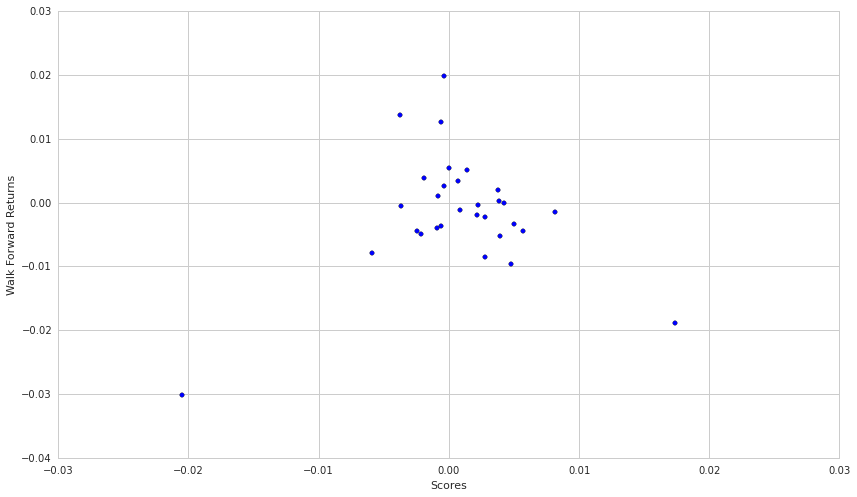

In [9]:
symbol_list = ['A', 'AA', 'AAC', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAU', 'AAV', 'AAVL', 'AAWW', 'AB', 'ABAC', 'ABAX', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG', 'ABGB']

# Get the returns over the lookback window
start = '2014-12-01'
end = '2015-01-01'
historical_returns = get_pricing(symbol_list, fields='price', start_date=start, end_date=end).pct_change()[1:]

# Compute our stock score
scores = np.mean(historical_returns)
print 'Our Scores\n'
print scores
print '\n'

start = '2015-01-01'
end = '2015-02-01'
walk_forward_returns = get_pricing(symbol_list, fields='price', start_date=start, end_date=end).pct_change()[1:]
walk_forward_returns = np.mean(walk_forward_returns)
print 'The Walk Forward Returns\n'
print walk_forward_returns
print '\n'

plt.scatter(scores, walk_forward_returns)
plt.xlabel('Scores')
plt.ylabel('Walk Forward Returns')

r_s = stats.spearmanr(scores, walk_forward_returns)
print 'Correlation Coefficient: ' + str(r_s[0])
print 'p-value: ' + str(r_s[1])

The p-value indicates that our hypothesis is false and we accept the null hypothesis that our ranking was no better than random. This is a really good check of any ranking system one devises for constructing a long-short equity portfolio.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*